# 07 - Metrics Overview\n
Inspection rapide des métriques pré-calculées (Elo, firsts, Roshan/Aegis, gold/xp buckets, séries).

In [11]:
import sys
from pathlib import Path

def _find_root():
    cand = Path.cwd()
    for c in [cand, *cand.parents]:
        if (c / 'src').exists() and (c / 'data').exists():
            return c
    return cand

ROOT = _find_root()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))
print(f'Using ROOT={ROOT}')

metrics_dir = ROOT / 'data/metrics'
if not metrics_dir.exists():
    raise FileNotFoundError(f'Metrics dir not found: {metrics_dir}. Lance `make precompute`.')

import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid')


Using ROOT=/home/ju/Documents/Dev/Dota-Datas


In [2]:
# Chargement des parquets métriques
elo_hist = pl.read_parquet(metrics_dir / 'elo_timeseries.parquet')
elo_latest = pl.read_parquet(metrics_dir / 'elo_latest.parquet')
firsts = pl.read_parquet(metrics_dir / 'firsts.parquet')
roshan = pl.read_parquet(metrics_dir / 'roshan.parquet')
gold_buckets = pl.read_parquet(metrics_dir / 'gold_buckets.parquet')
xp_buckets = pl.read_parquet(metrics_dir / 'xp_buckets.parquet')
series_maps = pl.read_parquet(metrics_dir / 'series_maps.parquet')
series_team = pl.read_parquet(metrics_dir / 'series_team_stats.parquet')
teams_lookup = pl.read_parquet(metrics_dir / 'tracked_teams.parquet') if (metrics_dir / 'tracked_teams.parquet').exists() else None

print('Shapes:')
for name, df in [
    ('elo_hist', elo_hist),
    ('elo_latest', elo_latest),
    ('firsts', firsts),
    ('roshan', roshan),
    ('gold_buckets', gold_buckets),
    ('xp_buckets', xp_buckets),
    ('series_maps', series_maps),
    ('series_team', series_team),
]:
    print(name, df.shape)


Shapes:
elo_hist (3879, 10)
elo_latest (24, 2)
firsts (48, 6)
roshan (24, 6)
gold_xp (753, 6)
series_maps (3879, 8)
series_team (102, 5)


team_id,elo
i64,f64
9247354,1774.775043
7119388,1721.631487
8291895,1713.98937
9572001,1713.398611
8255888,1683.130291
9338413,1674.083779
9255039,1661.525113
9823272,1645.016681
8261500,1620.412045


team_id,elo
i64,f64
9964962,1478.694448
7732977,1519.319752
7554697,1525.138999
9351740,1527.549596
9879291,1529.610693


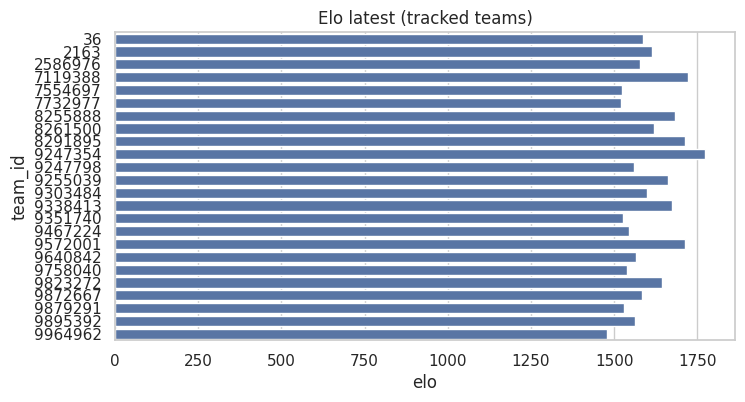

In [12]:
# Elo top/bottom
display(elo_latest.sort('elo', descending=True).head(10))
display(elo_latest.sort('elo', descending=False).head(5))
plt.figure(figsize=(8,4))
sns.barplot(data=elo_latest.sort('elo', descending=True).to_pandas(), x='elo', y='team_id', orient='h')
plt.title('Elo latest (tracked teams)')
plt.show()


In [13]:
# Teams sorted by current Elo (with names when available)
elo_named = elo_latest
if teams_lookup is not None:
    elo_named = elo_latest.join(teams_lookup.select(['team_id', 'name']), on='team_id', how='left')

display(elo_named.sort('elo', descending=True).to_pandas()[['team_id', 'name', 'elo']])


,team_id,name,elo
0,9247354,Team Falcons,1774.775043
1,7119388,Team Spirit,1721.631487
2,8291895,Tundra Esports,1713.989370
3,9572001,PARIVISION,1713.398611
4,9572001,PVISION,1713.398611
5,8255888,BetBoom Team,1683.130291
6,8255888,BB Team,1683.130291
7,9338413,MOUZ,1674.083779
8,9255039,1w Team,1661.525113
9,9823272,Team Yandex,1645.016681


team_id,team_is_radiant,first_blood_rate,first_tower_rate,first_roshan_rate,matches
i64,bool,f64,f64,f64,u32
36,false,0.518182,0.477477,0.513514,111
36,true,0.433735,0.547619,0.535714,84
2163,false,0.541353,0.402985,0.413534,134
2163,true,0.487805,0.526627,0.520958,169
2586976,false,0.59596,0.524752,0.55,101


team_id,matches,roshan_kills_avg,aegis_claims_avg,first_roshan_rate,steals_total
i64,u32,f64,f64,f64,i64
36,195,1.164103,1.138462,0.523077,6
2163,303,1.016502,0.990099,0.473333,10
2586976,250,1.132,1.1,0.565574,10
7119388,258,1.282946,1.248062,0.565217,8
7554697,247,1.129555,1.093117,0.589958,6


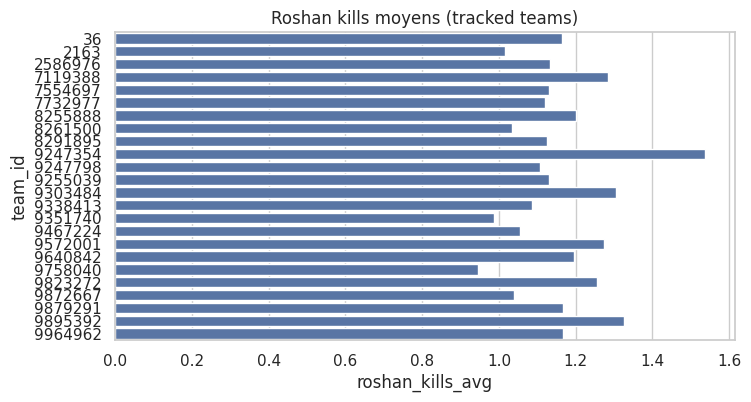

In [4]:
# Firsts et Roshan/Aegis
display(firsts.head())
display(roshan.head())
if not roshan.is_empty():
    plt.figure(figsize=(8,4))
    sns.barplot(data=roshan.to_pandas().sort_values('roshan_kills_avg', ascending=False), x='roshan_kills_avg', y='team_id', orient='h')
    plt.title('Roshan kills moyens (tracked teams)')
    plt.show()


team_id,minute,bucket_gold,winrate,matches,adv_gold_avg
i64,i64,str,f64,u32,f64
36,10,"""[-10k,-5k)""",0.0,3,-6331.666667
36,10,"""[-1k,0k)""",0.589744,39,-479.641026
36,10,"""[-5k,-1k)""",0.344262,61,-2210.57377
36,10,"""[0k,1k)""",0.685714,35,502.285714
36,10,"""[1k,5k)""",0.764706,51,2329.078431


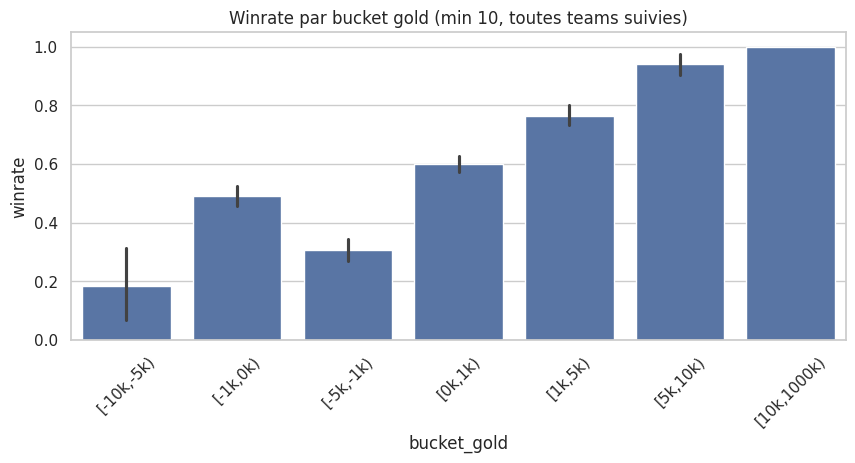

In [5]:
# Gold / XP buckets minute 10
gold10 = gold_buckets.filter(pl.col('minute') == 10)
display(gold10.head())
if not gold10.is_empty():
    plt.figure(figsize=(10,4))
    sns.barplot(data=gold10.to_pandas(), x='bucket', y='winrate')
    plt.title('Winrate by gold bucket (min 10, tracked teams)')
    plt.xticks(rotation=45)
    plt.show()

xp10 = xp_buckets.filter(pl.col('minute') == 10)
display(xp10.head())
if not xp10.is_empty():
    plt.figure(figsize=(10,4))
    sns.barplot(data=xp10.to_pandas(), x='bucket', y='winrate')
    plt.title('Winrate by XP bucket (min 10, tracked teams)')
    plt.xticks(rotation=45)
    plt.show()


series_id,series_type,map_num,match_id,start_time,radiant_team_id,dire_team_id,radiant_win
i64,i64,u32,i64,i64,i64,i64,bool
938783,0,2,8111128474,1735902662,9640842,8591706,true
939334,0,2,8115341162,1736101789,9338413,9646467,false
939634,1,2,8117455712,1736222415,7732977,9546449,true
939641,1,2,8117506486,1736226982,7732977,8944230,true
939650,1,2,8117622869,1736237323,9634632,9467224,false


team_id,map_num,winrate,maps_played,series_type_sample
i64,i64,f64,u32,i64
36,2,0.626374,91,1
36,3,0.544118,68,1
36,4,0.53125,32,1
36,5,0.5,2,2
36,6,0.5,2,2


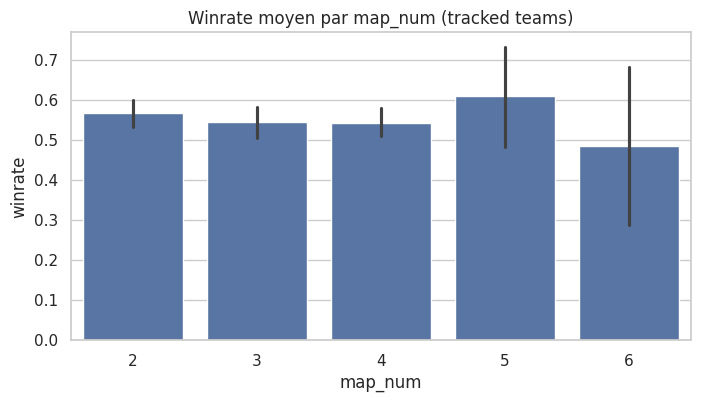

In [6]:
# Séries : distribution des maps par series_id et winrates par map_num
display(series_maps.head())
display(series_team.head())
if not series_team.is_empty():
    plt.figure(figsize=(8,4))
    sns.barplot(data=series_team.to_pandas(), x='map_num', y='winrate')
    plt.title('Winrate moyen par map_num (tracked teams)')
    plt.show()


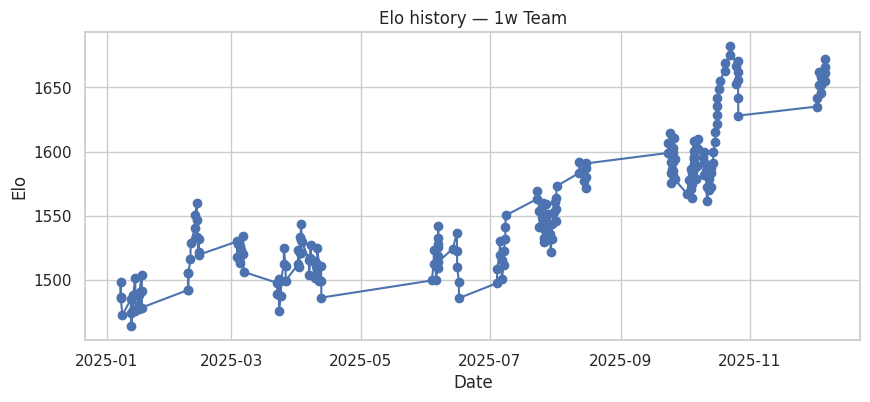

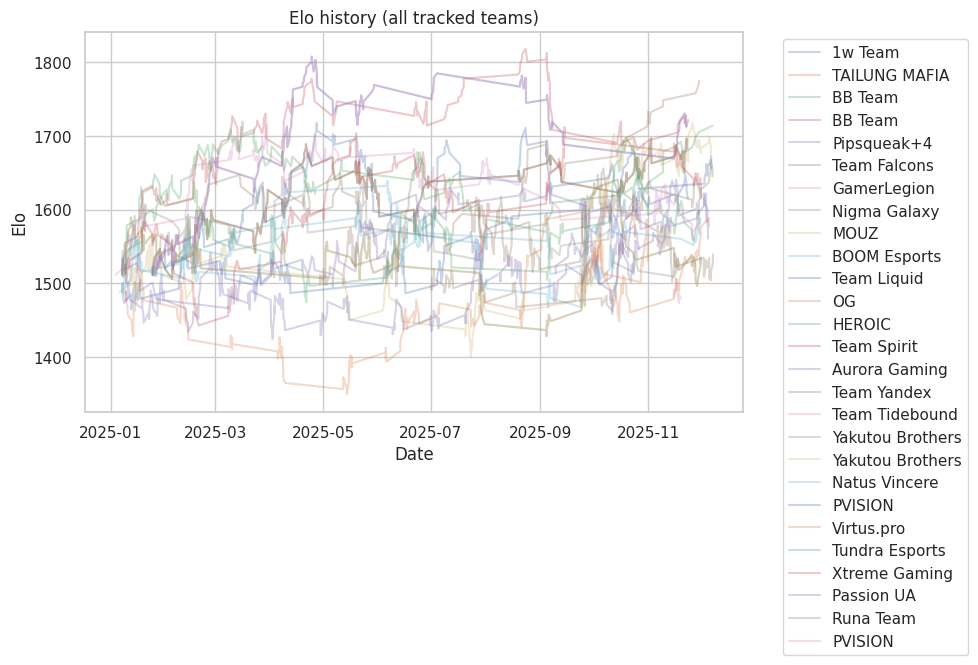

In [9]:
# Courbes Elo par équipe suivie (labels avec noms)
if teams_lookup is not None:
    team_ids = teams_lookup['team_id'].to_list()
    id_to_name = {r['team_id']: r['name'] for r in teams_lookup.to_dicts()}
else:
    team_ids = elo_latest['team_id'].to_list()
    id_to_name = {r['team_id']: str(r['team_id']) for r in elo_latest.to_dicts()}

team_id = team_ids[0]
team_label = id_to_name.get(team_id, str(team_id))
elo_team = elo_hist.filter(pl.col('team_id') == team_id).sort('start_time')
df_elo = elo_team.to_pandas()
df_elo['start_dt'] = pd.to_datetime(df_elo['start_time'], unit='s')
plt.figure(figsize=(10,4))
plt.plot(df_elo['start_dt'], df_elo['rating_post'], marker='o')
plt.title(f"Elo history — {team_label}")
plt.xlabel('Date')
plt.ylabel('Elo')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
for tid in team_ids:
    elo_t = elo_hist.filter(pl.col('team_id') == tid).sort('start_time')
    df_t = elo_t.to_pandas()
    df_t['start_dt'] = pd.to_datetime(df_t['start_time'], unit='s')
    plt.plot(df_t['start_dt'], df_t['rating_post'], alpha=0.3, label=id_to_name.get(tid, str(tid)))
plt.title('Elo history (all tracked teams)')
plt.xlabel('Date')
plt.ylabel('Elo')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()
